<a href="https://colab.research.google.com/github/dnevo/Practicum/blob/master/S08_Supervised_learning_predict_bank_customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Отток клиентов

## Описание проекта
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

**Инструкция по выполнению проекта**
1. Загрузите и подготовьте данные. Поясните порядок действий.
1. Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
1. Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.
1. Проведите финальное тестирование.

**Описание данных**

Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»).

**Признаки**

1. RowNumber — индекс строки в данных
1. CustomerId — уникальный идентификатор клиента
1. Surname — фамилия
1. CreditScore — кредитный рейтинг
1. Geography — страна проживания
1. Gender — пол
1. Age — возраст
1. Tenure — количество недвижимости у клиента
1. Balance — баланс на счёте
1. NumOfProducts — количество продуктов банка, используемых клиентом
1. HasCrCard — наличие кредитной карты
1. IsActiveMember — активность клиента
1. EstimatedSalary — предполагаемая зарплата

**Целевой признак**

1. Exited — факт ухода клиента

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:11,.2f}'.format

In [2]:
#df = pd.read_csv('https://github.com/PhoenixAnalist/YandexProjects/blob/master/Project6/Churn.csv')
#пока не разобрался как с гитхаба открывать файлы csv.
df = pd.read_csv('C:/Users/Миша/Documents/PythonYandex/YandexProjects/Project6/Churn.csv')
#df = pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
3,4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0


In [3]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,"10,000.00","10,000.00","10,000.00","10,000.00","9,091.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,"5,000.50","15,690,940.57",650.53,38.92,5.00,"76,485.89",1.53,0.71,0.52,"100,090.24",0.20
std,"2,886.90","71,936.19",96.65,10.49,2.89,"62,397.41",0.58,0.46,0.50,"57,510.49",0.40
min,1.00,"15,565,701.00",350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,"2,500.75","15,628,528.25",584.00,32.00,2.00,0.00,1.00,0.00,0.00,"51,002.11",0.00
50%,"5,000.50","15,690,738.00",652.00,37.00,5.00,"97,198.54",1.00,1.00,1.00,"100,193.91",0.00
75%,"7,500.25","15,753,233.75",718.00,44.00,7.00,"127,644.24",2.00,1.00,1.00,"149,388.25",0.00
max,"10,000.00","15,815,690.00",850.00,92.00,10.00,"250,898.09",4.00,1.00,1.00,"199,992.48",1.00


Как можно заметить выше, в столбце отсутствуют значения Tenure

In [4]:
print(df['Geography'].value_counts(normalize=True))
print(df['Exited'].value_counts(normalize=True))

print(df[df['Tenure'].isna()]['Geography'].value_counts(normalize=True))
print(df[df['Tenure'].isna()]['Exited'].value_counts(normalize=True))

France           0.50
Germany          0.25
Spain            0.25
Name: Geography, dtype: float64
0          0.80
1          0.20
Name: Exited, dtype: float64
France           0.51
Spain            0.25
Germany          0.24
Name: Geography, dtype: float64
0          0.80
1          0.20
Name: Exited, dtype: float64


Как отмечено выше, ряды NaN распределяются аналогично остальным рядам.
Поэтому мы можем убрать эти строки:

In [5]:
df.dropna(inplace=True)
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,"9,091.00","9,091.00","9,091.00","9,091.00","9,091.00","9,091.00","9,091.00","9,091.00","9,091.00","9,091.00","9,091.00"
mean,"5,013.91","15,691,053.16",650.74,38.95,5.00,"76,522.74",1.53,0.70,0.52,"100,181.21",0.20
std,"2,884.43","71,614.19",96.41,10.56,2.89,"62,329.53",0.58,0.46,0.50,"57,624.76",0.40
min,1.00,"15,565,701.00",350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,"2,521.50","15,628,985.50",584.00,32.00,2.00,0.00,1.00,0.00,0.00,"51,227.74",0.00
50%,"5,019.00","15,691,061.00",652.00,37.00,5.00,"97,318.25",1.00,1.00,1.00,"100,240.20",0.00
75%,"7,511.50","15,752,851.50",717.00,44.00,7.00,"127,561.89",2.00,1.00,1.00,"149,567.21",0.00
max,"9,999.00","15,815,660.00",850.00,92.00,10.00,"250,898.09",4.00,1.00,1.00,"199,992.48",1.00


Как и выше, нет пропущенных значений

In [6]:
df['Geography'].value_counts()

France     4550
Germany    2293
Spain      2248
Name: Geography, dtype: int64

Как указано выше, клиенты из всего 3 стран, и большее количество из них из Франции.

In [7]:
df['Exited'].value_counts()

0    7237
1    1854
Name: Exited, dtype: int64

соотношение 4 ('Exited' = 0) к 1 ('Exited' = 1)

Удаляем из данных CustomerId и Surname, поскольку они в анализе они не нужны:

In [8]:
df.drop(columns=['CustomerId', 'Surname'],inplace=True)

OHE для Gender и Geography:

In [9]:
df = pd.get_dummies(df, columns=['Gender', 'Geography'], drop_first=True)
df.head()

,RowNumber,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,1,619,42,2.00,0.00,1,1,1,"101,348.88",1,0,0,0
1,2,608,41,1.00,"83,807.86",1,0,1,"112,542.58",0,0,0,1
2,3,502,42,8.00,"159,660.80",3,1,0,"113,931.57",1,0,0,0
3,4,699,39,1.00,0.00,2,0,0,"93,826.63",0,0,0,0
4,5,850,43,2.00,"125,510.82",1,1,1,"79,084.10",0,0,0,1


Набор данных разбит на 3 группы: train 60%, Validation 20%, test 20%.

Поскольку метод train_test_split предназначен для разделения только на 2 группы, мы вызываем его дважды, чтобы разделить на три. Было разделение на 2 группы.

In [10]:
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=12345)
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=12345)
features_train = df_train.drop(['Exited'], axis=1)
target_train = df_train['Exited']
features_valid = df_valid.drop(['Exited'], axis=1)
target_valid = df_valid['Exited']
features_test = df_test.drop(['Exited'], axis=1)
target_test = df_test['Exited']

In [11]:
def learning (train_scores, valid_scores, param_range, target):
    plt.figure(figsize=(9, 9))
    targets = [target]* len(train_scores)
    plt.plot(param_range, train_scores, 'o-', color="r", label="Training")
    plt.plot(param_range, valid_scores, 'o-', color="b", label="Validation")
    plt.plot(param_range, targets,'-', color="g", label="Target")
    plt.ylabel('Score') 
    plt.title('Learning')
    plt.legend()
    plt.grid()
    plt.show()

# Оценка моделей без балансировки классов

Логистическая регрессия без балансировки. Видим очень плохие результаты: F1 = 0,08

In [12]:
model = LogisticRegression(random_state=12345, class_weight=None)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predictions_valid))

F1: 0.0857142857142857


Decision Tree без балансировки F1 score: 0.57

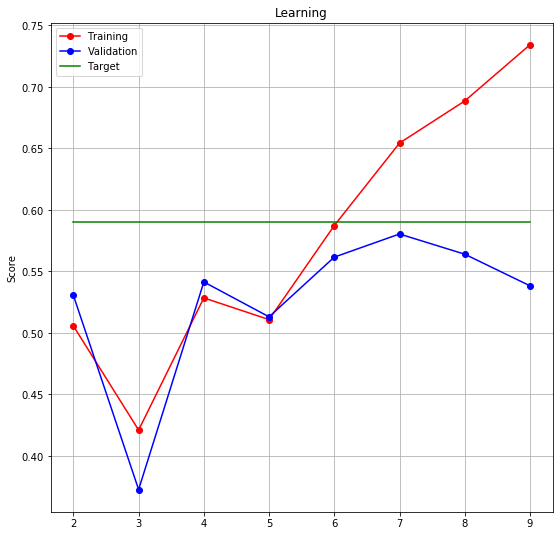

In [13]:
train_f1_scores = []
valid_f1_scores = []
param_range = []
for depth in range(2,10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight=None)
    model.fit(features_train, target_train)
    param_range.append(depth)
    train_f1_scores.append(f1_score(target_train, model.predict(features_train)))
    valid_f1_scores.append(f1_score(target_valid, model.predict(features_valid)))
learning(train_f1_scores, valid_f1_scores, param_range, 0.59)

Random Forest без сбалансированного веса, найден оптимальный max_depth, и найден оптимальны n_estimators

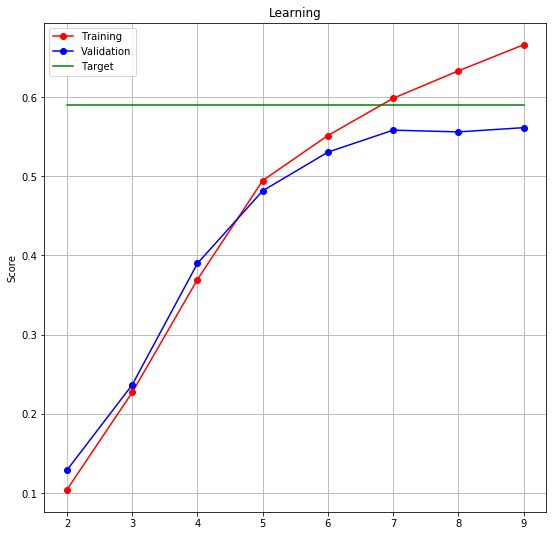

In [14]:
train_f1_scores = []
valid_f1_scores = []
param_range = []
for depth in range(2,10):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, class_weight=None)
    model.fit(features_train, target_train)
    param_range.append(depth)
    train_f1_scores.append(f1_score(target_train, model.predict(features_train)))
    valid_f1_scores.append(f1_score(target_valid, model.predict(features_valid)))
learning (train_f1_scores, valid_f1_scores, param_range, 0.59)

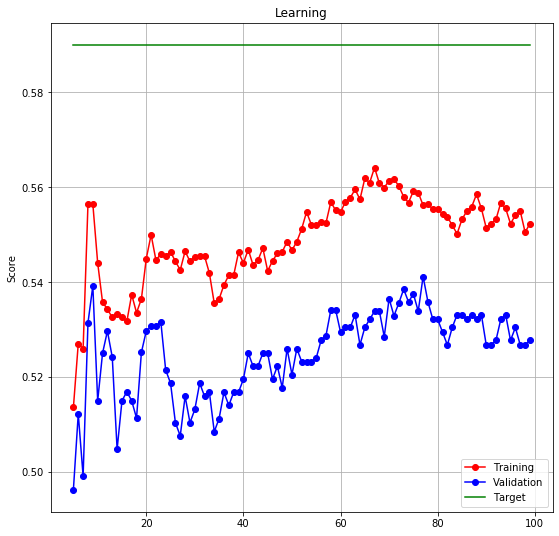

In [15]:
train_f1_scores = []
valid_f1_scores = []
param_range = []
for n_estim in range(5,100):
    model = RandomForestClassifier(random_state=12345, n_estimators=n_estim, class_weight=None, max_depth=6)
    model.fit(features_train, target_train)
    param_range.append(n_estim)
    train_f1_scores.append(f1_score(target_train, model.predict(features_train)))
    valid_f1_scores.append(f1_score(target_valid, model.predict(features_valid)))
learning (train_f1_scores, valid_f1_scores, param_range, 0.59)

Как и выше, без балансировки классов результаты не очень хорошие. Намного ниже целевого показателя 0,59!

# Оценка моделей с Upsampling

In [16]:
from sklearn.utils import shuffle

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [17]:
model = LogisticRegression()
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4780405405405405


Как и выше, повышающая выборка обеспечивает преимущество по сравнению с исходной моделью логистической регрессии

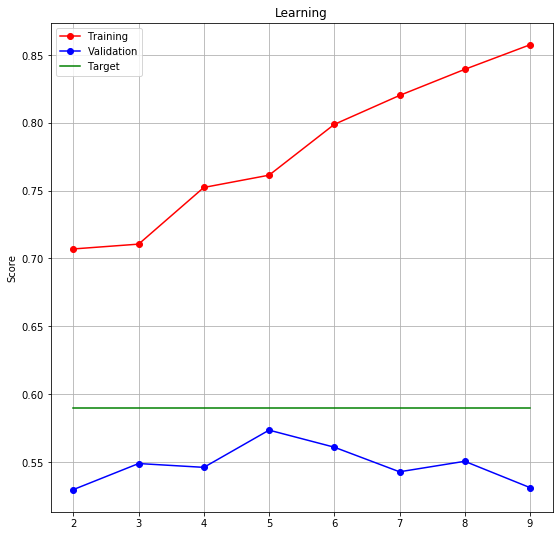

In [18]:
train_f1_scores = []
valid_f1_scores = []
param_range = []
for depth in range(2,10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight=None)
    model.fit(features_upsampled, target_upsampled)
    param_range.append(depth)
    train_f1_scores.append(f1_score(target_upsampled, model.predict(features_upsampled)))
    valid_f1_scores.append(f1_score(target_valid, model.predict(features_valid)))
learning (train_f1_scores, valid_f1_scores, param_range, 0.59)

Upsampling обеспечивает некоторое улучшение для Decision Tree, но недостаточно для достижения 0,59

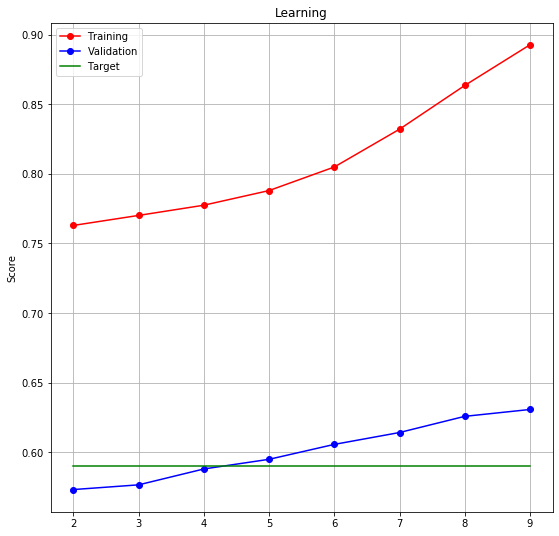

In [19]:
train_f1_scores = []
valid_f1_scores = []
param_range = []
for depth in range(2,10):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, class_weight=None)
    model.fit(features_upsampled, target_upsampled)
    param_range.append(depth)
    train_f1_scores.append(f1_score(target_upsampled, model.predict(features_upsampled)))
    valid_f1_scores.append(f1_score(target_valid, model.predict(features_valid)))
learning(train_f1_scores, valid_f1_scores, param_range, 0.59)

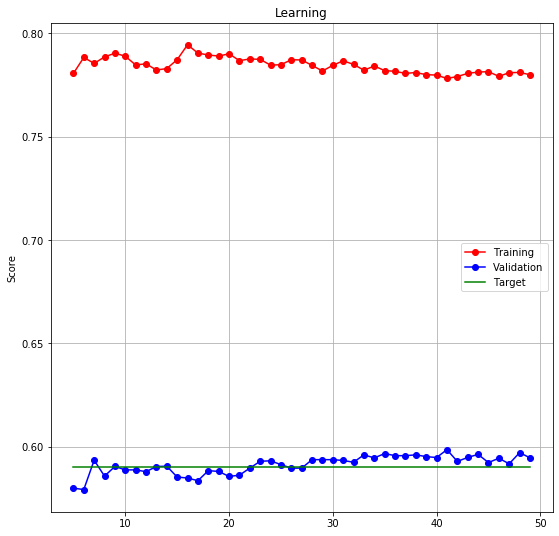

In [20]:
train_f1_scores = []
valid_f1_scores = []
param_range = []
for n_estim in range(5,50):
    model = RandomForestClassifier(random_state=12345, n_estimators=n_estim, class_weight=None, max_depth=5)
    model.fit(features_upsampled, target_upsampled)
    param_range.append(n_estim)
    train_f1_scores.append(f1_score(target_upsampled, model.predict(features_upsampled)))
    valid_f1_scores.append(f1_score(target_valid, model.predict(features_valid)))
learning (train_f1_scores, valid_f1_scores, param_range, 0.59)

Random Forrest с Upsampling: хотя в соответствии с приведенным выше графиком пересечение целевого показателя 0,59 достигнуто, результат не является удовлетворительным, поскольку между оценочным набором и проверочным набором имеется большой разрыв (примерно 15%), что указывает на переобучение.

# Оценка моделей с балансировкой классов

Logistic Regression с балансировкой как ниже. Плохие результаты - F1=0.49

In [21]:
model = LogisticRegression(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predictions_valid))

F1: 0.48041775456919056


Decision Tree с балансировкой - F1 score: 0.575 - ниже нужного результата 0.59

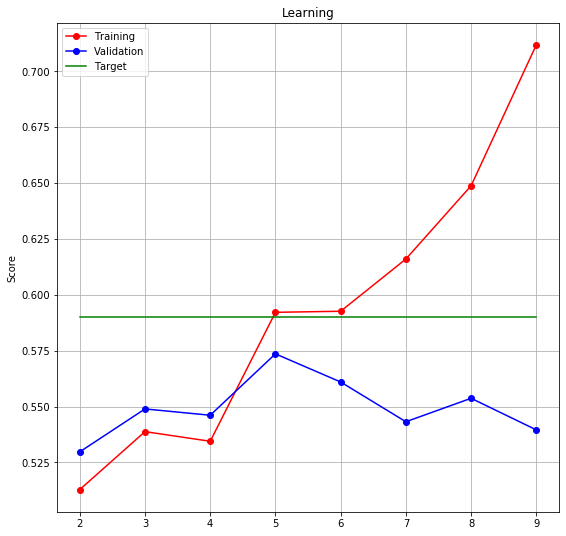

In [22]:
train_f1_scores = []
valid_f1_scores = []
param_range = []
for depth in range(2,10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    param_range.append(depth)
    train_f1_scores.append(f1_score(target_train, model.predict(features_train)))
    valid_f1_scores.append(f1_score(target_valid, model.predict(features_valid)))
learning (train_f1_scores, valid_f1_scores, param_range, 0.59)

Random Forest со сбалансированным весом - найден оптимальный max_depth

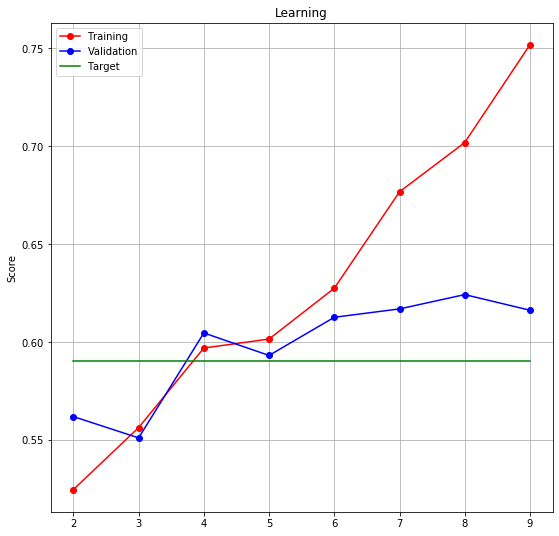

In [23]:
train_f1_scores = []
valid_f1_scores = []
param_range = []
for depth in range(2,10):
    model = RandomForestClassifier(random_state=12345, n_estimators=10, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    param_range.append(depth)
    train_f1_scores.append(f1_score(target_train, model.predict(features_train)))
    valid_f1_scores.append(f1_score(target_valid, model.predict(features_valid)))
learning (train_f1_scores, valid_f1_scores, param_range, 0.59)

После того, как мы нашли оптимальную глубину (6), мы будем искать оптимальные n_estimators

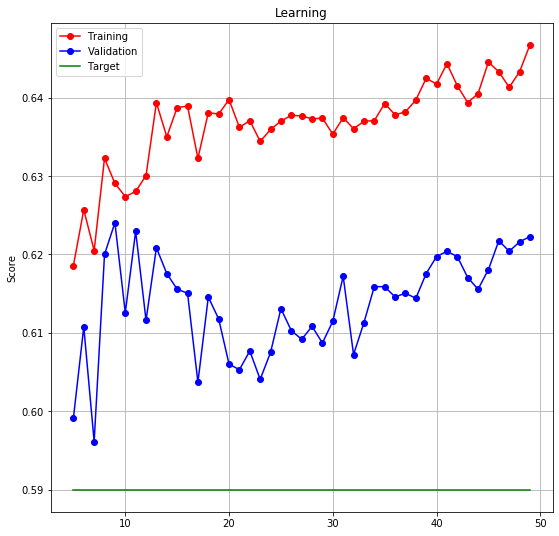

In [24]:
train_f1_scores = []
valid_f1_scores = []
param_range = []
for n_estim in range(5,50):
    model = RandomForestClassifier(random_state=12345, n_estimators=n_estim, class_weight='balanced', max_depth=6)
    model.fit(features_train, target_train)
    param_range.append(n_estim)
    train_f1_scores.append(f1_score(target_train, model.predict(features_train)))
    valid_f1_scores.append(f1_score(target_valid, model.predict(features_valid)))
learning (train_f1_scores, valid_f1_scores, param_range, 0.59)

n_estim = 35 Оптимальна. (для более высоких значений разрыв между f1_valid и f1_train начинает расти)

RandomForest: после оптимизации гиперпараметров проверяем `F1` и` ROC-AUC` в тестовом наборе:

In [25]:
model = RandomForestClassifier(random_state=12345, n_estimators=35, class_weight='balanced', max_depth=6)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print('Test set F1', f1_score(target_test, predictions_test))
print('Test set ROC-AUC', roc_auc_score(target_test, predictions_test))

Test set F1 0.5837209302325581
Test set ROC-AUC 0.7696751981493126


Как указано выше, F1 составляет 0,595, что является нормой (выше целевого показателя 0,59), а ROC-AUC составляет 0,776 (по сравнению со случайной моделью: 0,5).

# Выводы
- Классы сбалансированы без соотношения 4: 1
- используя весовые коэффициенты класса, мы смогли достичь удовлетворительных результатов (F1 = 0,595, ROC-AUC = 0,776)
- Были оценены три модели: логистическая регрессия, дерево решений и случайный лес
Случайный Лес - Победил!